@Author: Ben Funk

**Overview of Code**
This Python code is aimed at performing statistical analysis and modeling on a dataset with the goal of predicting a target variable, in this case, 'Target PPM'. The data set is imported from a CSV file named 'BenSummaryJustMatrix.csv'. This dataset consists of features including 'Resistance', 'Ratio', 'RelativeHumidity', 'Temperature', and the target variable 'Target PPM'.

**Initial Setup and Data Preprocessing**
The necessary libraries, including numpy, pandas, scipy, matplotlib, and sklearn, are first imported. Then, the dataset is loaded, and the different features along with the target variable are separated into different variables for easier processing.

Next, the code splits the data into training and testing sets using sklearn's train_test_split function. It also generates a scatter plot of 'Resistance' against 'Target PPM', with the color of the data points representing 'RelativeHumidity'.

**Custom Function Fitting and Evaluation**
The code defines two custom functions (funct3 and funct) with different mathematical forms, aiming to model the relationship between the features ('Resistance', 'RelativeHumidity', 'Temperature') and the target variable.

These functions are then fitted to the data using scipy.optimize.curve_fit, which performs a non-linear least squares optimization to find the best-fitting parameters. The Root Mean Squared Error (RMSE) is then calculated to quantify the model performance.

For each target PPM value, the 95% confidence interval is also computed using the scipy.stats.t.interval function, and the results are printed.

**Residual Analysis and Goodness-of-Fit Evaluation**
Finally, the code performs residual analysis and checks the goodness-of-fit of the models:

R-Squared: It calculates the R-squared value to quantify the proportion of the variance in the dependent variable that is predictable from the independent variables.

Q-Q Plot: The quantile-quantile (Q-Q) plot is generated using statsmodels.api.qqplot to check the normality of the residuals.

Residual vs. Predicted Plot: This plot is used to visualize potential heteroscedasticity in the residuals.

F-Statistic and P-Value: The F-statistic and its associated p-value are computed to test the overall significance of the model.

This entire process is repeated for both custom functions (funct3 and funct). The code output provides a comprehensive understanding of how well the models fit the data and can predict 'Target PPM' from the given features.

Before running this code, make sure the required libraries are installed and the dataset file ('BenSummaryJustMatrix.csv') is available in the specified directory ('Output/').

In [27]:
# Relevant libraries
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [28]:
# Load data from CSV file
file2 = pd.read_csv("Output/BenSummaryJustMatrix.csv")

# Extract the columns from the data
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


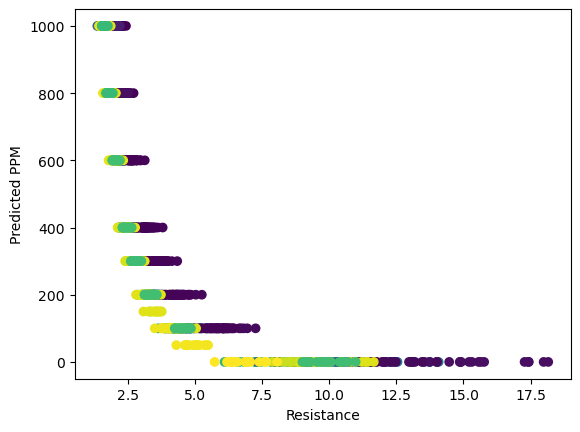

In [29]:
df = file2
plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
plt.show()

Accuracy of equation

0-1000
Resistance: RMSE 111.6
Resistance+Humidity: RMSE 88.1
Resistance+Temperature: RMSE 111.3
Resistance+Humidity+Temperature: RMSE: 77.6

0-500
Resistance: RMSE 60.7
Resistance+Humidity: RMSE 47.9
Resistance+Temperature: RMSE 60.7
Resistance+Humidity+Temperature: RMSE: 44.3

In [36]:
# Funk Equation
#+ g * np.exp(-1 * T*h + i)
def funct3(X, a, b, c, d, e,f,g,h,i,j):
    R, H, T = X
    return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
p0 = 1,1,.5,1,1,1,1,1,1,1

# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM,p0, maxfev=1000000)

# Print the optimized parameters
print(popt)

[ 3.57271065e+01  8.44912494e-01  4.71358735e+00  6.52881211e+00
  6.83799221e-02  4.37633634e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -7.36457119e+01]


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_33360/1105021380.py:5: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_33360/1105021380.py:5: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
/Users/benfunk/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [37]:
# file2=file2[file2["SensorID"]==3]
# X = file2.drop('Target PPM', axis='columns')
# y = file2.loc[:, 'Target PPM']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct3((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):

    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct3((df.loc[:, 'Resistance'],df.loc[:, 'RelativeHumidity'], df.loc[:, 'Temperature']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

77.37757533795755
The 95% Confidence Interval for 0 is (-7.573694051037355, 11.506660629531387)
The 95% Confidence Interval for 200 is (206.30862359055328, 217.77656431840154)
The 95% Confidence Interval for 400 is (441.43180510253575, 459.632445472287)
The 95% Confidence Interval for 600 is (612.9716206238767, 634.2753321628371)
The 95% Confidence Interval for 800 is (764.8849316309328, 788.6508955550343)
The 95% Confidence Interval for 1000 is (910.8564039444622, 940.0082880571368)


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_33360/4216764472.py:27: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))


R-squared:  0.9425809732540543


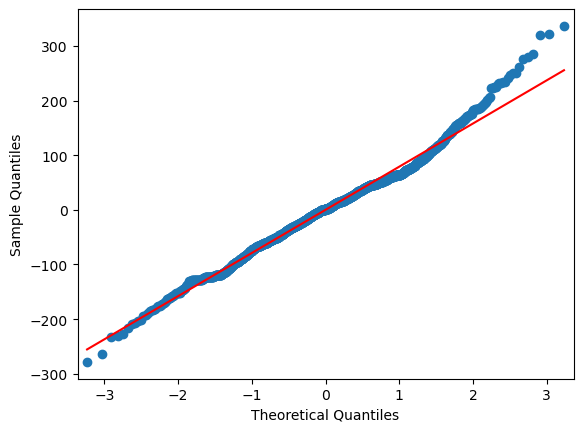

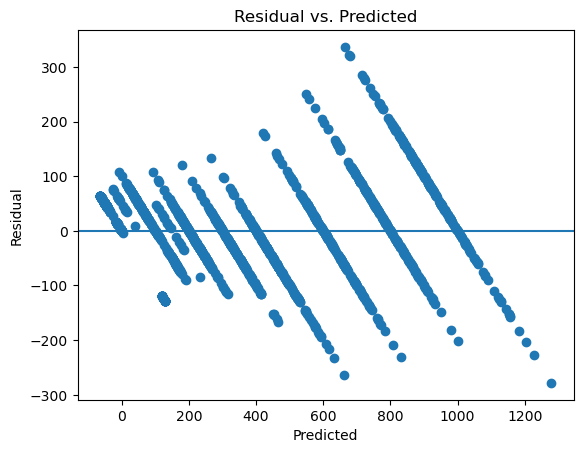

F-statistic: 2958.4973353144696
p-value: 0.0


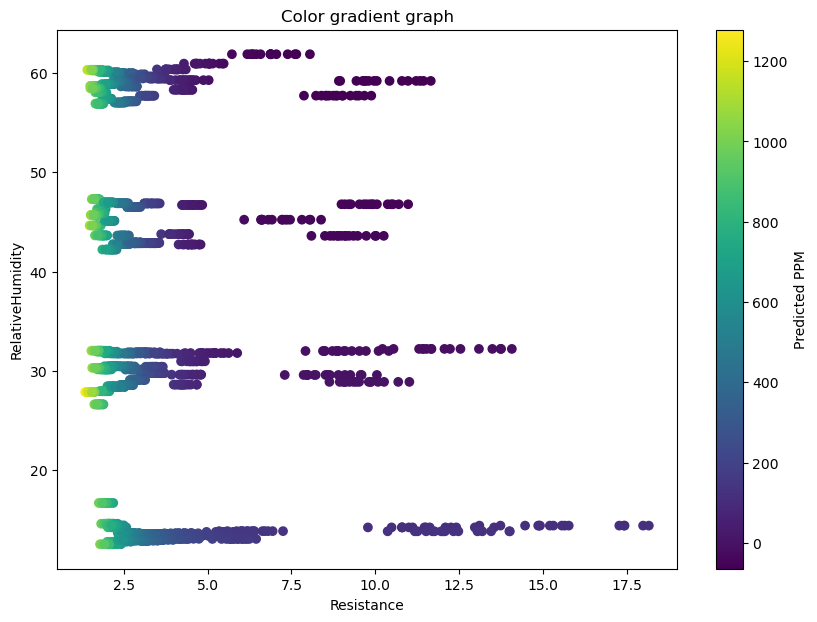

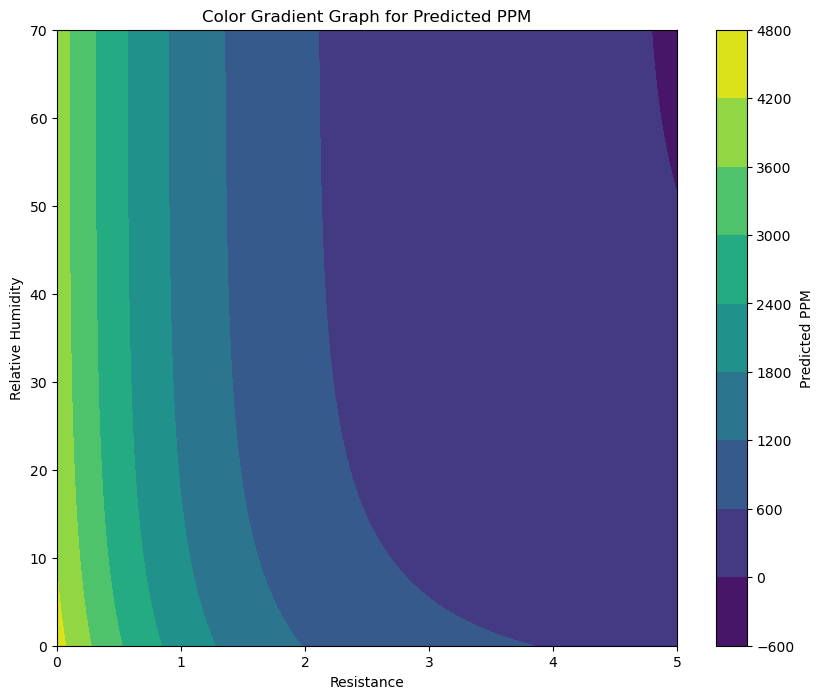

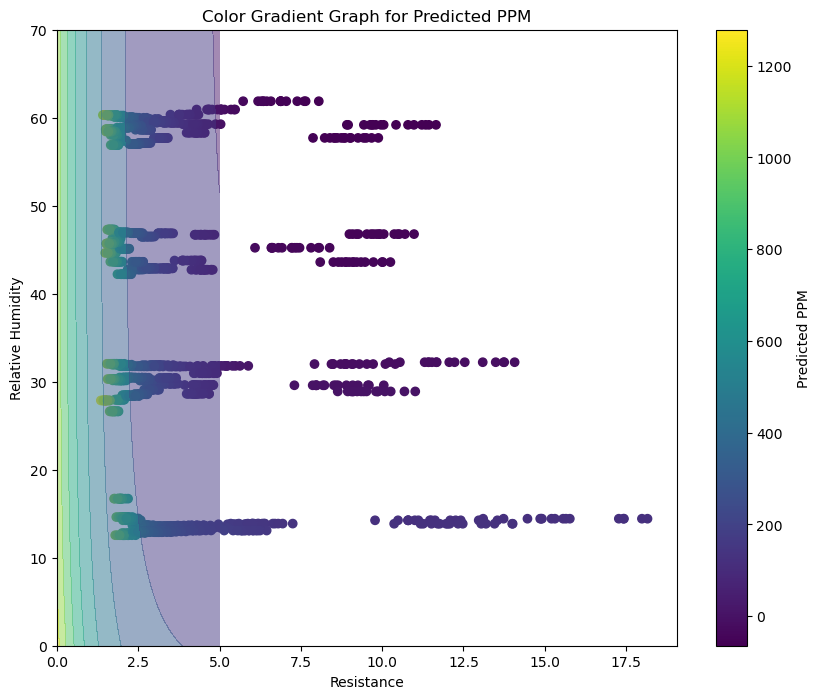

In [50]:
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt


y_pred = funct3((xDataResistance,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)

plt.figure(figsize=(10,7))
# Create a scatter plot, with the color determined by y_pred
sc = plt.scatter(xDataResistance, xDataRH, c=y_pred, cmap='viridis')
# Create a colorbar
plt.colorbar(sc, label='Predicted PPM')
plt.xlabel('Resistance')
plt.ylabel('RelativeHumidity')
plt.title('Color gradient graph')
plt.show()

resistance_range = np.linspace(0, 5, 1000)  # 10000 points between 0 and 1000
rh_range = np.linspace(0, 70, 1000)  # 10000 points between 0 and 100

# Create a grid of Resistance and RelativeHumidity values
resistance_values, rh_values = np.meshgrid(resistance_range, rh_range)


# Compute predicted PPM for all combinations of Resistance and RelativeHumidity
pred_ppm = funct3((resistance_values, rh_values,0), *popt)

# Create a color gradient graph
plt.figure(figsize=(10, 8))
plt.contourf(resistance_values, rh_values, pred_ppm, cmap='viridis')
plt.colorbar(label='Predicted PPM')
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Color Gradient Graph for Predicted PPM')
plt.show()

# Create a figure
plt.figure(figsize=(10,8))

# Draw the scatter plot
sc = plt.scatter(xDataResistance, xDataRH, c=y_pred, cmap='viridis')

# Compute predicted PPM for all combinations of Resistance and RelativeHumidity
pred_ppm = funct3((resistance_values, rh_values, 0), *popt)

# Draw the contour plot
plt.contourf(resistance_values, rh_values, pred_ppm, cmap='viridis', alpha=0.5)  # The alpha argument specifies the transparency of the contour plot

# Create a colorbar
plt.colorbar(sc, label='Predicted PPM')

# Label axes and title
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Color Gradient Graph for Predicted PPM')

# Show the plot
plt.show()

In [ ]:
def funct(X, a, b, c, d,e, f,g):
    R, H, T = X
    return a*R**b+c*H**d+e*(T+30)**f+g
p0 = 1,1,.5,1,1,1,1
# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM, maxfev=1000000)

# Print the optimized parameters
print(popt)

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):
    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct((df.loc[:, 'Resistance'],df.loc[:, 'RelativeHumidity'], df.loc[:, 'Temperature']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

In [ ]:
# adds function to view predicted ppm across temperatures while holding ppm and humidity constant
import matplotlib.cm as cm

file2 = pd.read_csv("Output/BenSummaryJustMatrix.csv")
file2=file2[file2["Target PPM"]<=0]
file2=file2[file2["RelativeHumidity"]<=50]
file2=file2[file2["RelativeHumidity"]>=40]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

df = file2
y_pred = funct3((xDataResistance,xDataRH, xDataTemp), *popt)
df['Predicted PPM'] = y_pred
# Create a scatter plot with colorbar
sc = plt.scatter(df.loc[:, "Temperature"],y_pred, c=xDataResistance, cmap=cm.viridis)
plt.colorbar(sc, label='Resistance Ratio')
plt.xlabel("Temperature")
plt.ylabel('Predicted PPM')

# Calculate mean prediction for each temperature and plot it
mean_pred_per_temp = df.groupby('Temperature')['Predicted PPM'].mean()
plt.plot(mean_pred_per_temp.index, mean_pred_per_temp.values, color='r', label='Mean prediction per temperature')
plt.legend()
plt.title('Temperature at 0 PPM')

plt.show()